In [9]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np
import xarray as xr
import copy
from tqdm import tqdm

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Read

### Obs

Using 2 observational realisations


/home/amosm1/bayesian_ensembling/ensembles/data.py:289: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")


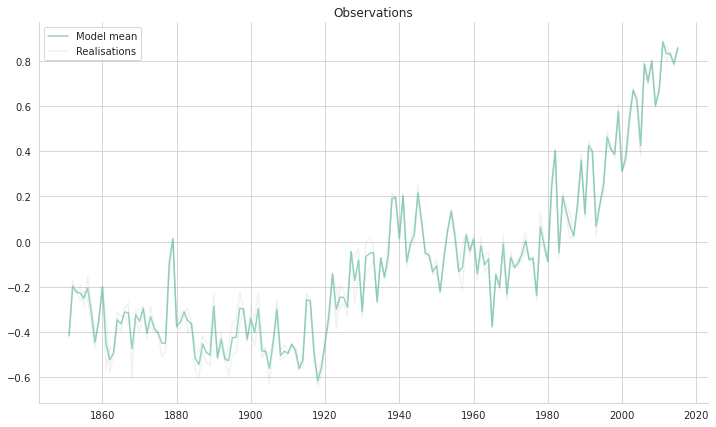

In [11]:
n_obs_realisations = 2
obs_da = xr.open_mfdataset(glob('data/obs/gridded/Had*.nc'), combine='nested', concat_dim='realization').tas[:n_obs_realisations].load()
obs_da = obs_da.rename(realization='realisation')
obs_da = obs_da.sel(time=slice('1850-01-01', '2014-12-31'))
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')
print(f'Using {n_obs_realisations} observational realisations')
observations.plot()
sns.despine()

## Models

Currently subsetting the ssp models in time to make the barycentre computation tolerable

In [12]:
def prepro(ds):
    model_real = ds.encoding['source'].split('_')[-1][:-3]
    ds = ds.assign_coords(realisation=model_real)
    if 'height' in ds.coords:
        ds = ds.drop('height')
    return ds

In [13]:
# TODO: Do a thorough assessment of physics, and forcing realisations to use
hist_model_files = glob('data/gridded/historical/*.nc')
ssp_model_files = glob('data/gridded/ssp245/*.nc')

hist_model_names = np.unique(['_'.join(file.split('/')[-1].split('_')[:2]) for file in hist_model_files])
ssp_model_names = np.unique(['_'.join(file.split('/')[-1].split('_')[:2]) for file in ssp_model_files])

unique_models = np.intersect1d(hist_model_names, ssp_model_names)

# Load hist
hist_anom_models = []
climatology_dict = dict()
for model_name in tqdm(unique_models):
    model_files = [file for file in hist_model_files if model_name + '_' in file]
    da = xr.open_mfdataset(model_files, preprocess=prepro, combine='nested', concat_dim='realisation').tas.load()
    da['time'] = obs_time # Replace time with observational time to avoid later problems
    model_data = es.ProcessModel(da, model_name)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
    hist_anom_models.append(anomaly_model)
    climatology_dict[model_name] = anomaly_model.climatology

# Load ssp
ssp_anom_models = []
for model_name in tqdm(unique_models):
    model_files = [file for file in ssp_model_files if model_name + '_' in file]
    da = xr.open_mfdataset(model_files, preprocess=prepro, combine='nested', concat_dim='realisation').tas.load()[:, 35 * 12: 35 * 12 + 48]
    # Convert time out of cftime to help matplotlib
    # Change time coord to something generic
    time = da.indexes['time']
    if not isinstance(time, DatetimeIndex):
        datetimeindex = da.indexes['time'].to_datetimeindex()
        da['time'] = datetimeindex
    model_data = es.ProcessModel(da, model_name)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y', climatology=climatology_dict[model_name])
    ssp_anom_models.append(anomaly_model)

hist_anom_models = es.ModelCollection(hist_anom_models)
ssp_anom_models = es.ModelCollection(ssp_anom_models)


  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_3072682/115768439.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da.indexes['time'].to_datetimeindex()
  7%|▋         | 1/15 [00:00<00:13,  1.07it/s]/tmp/ipykernel_3072682/115768439.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da.indexes['time'].to_datetimeindex()
 53%|█████▎    | 8/15 [00:02<00:01,  3.84it/s]/tmp/ipykernel_3072682/115768439.py:33: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, 

/home/amosm1/bayesian_ensembling/ensembles/data.py:525: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:525: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:525: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:525: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:525: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py

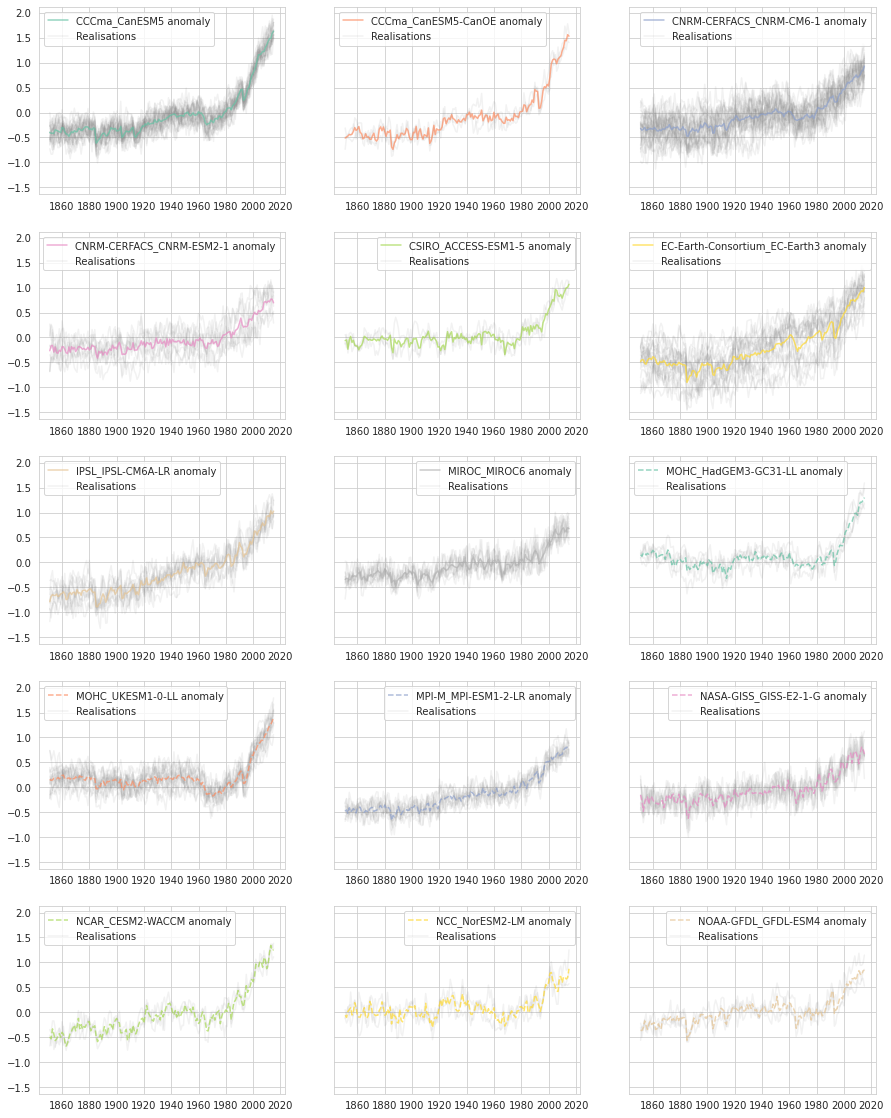

In [14]:
hist_anom_models.plot_grid()

/home/amosm1/bayesian_ensembling/ensembles/data.py:497: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:497: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:497: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:497: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py:497: UserWarning: Collapsing (mean) non-time dimensions for plotting
  warnings.warn("Collapsing (mean) non-time dimensions for plotting")
/home/amosm1/bayesian_ensembling/ensembles/data.py

<AxesSubplot:>

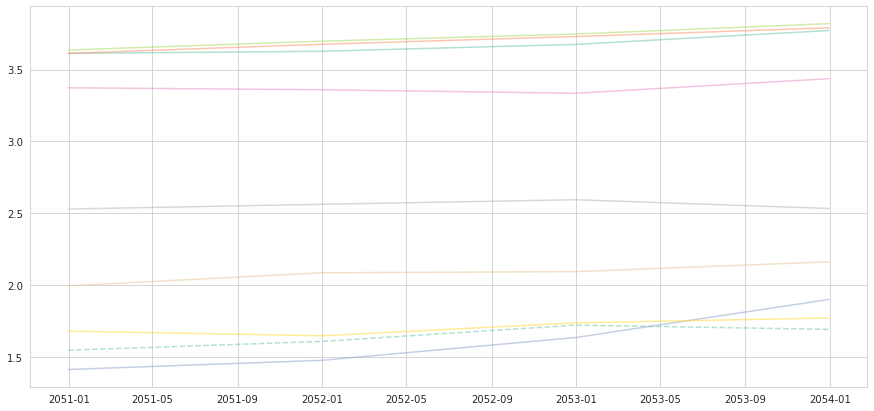

In [6]:
ssp_anom_models.plot_all()

Fit the process models using either mean field approximation or GPDTW

In [13]:
ssp_anom_models.fit(model=es.GPDTW3D(), compile_objective=False, n_optim_nits=100)

/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "


(10368, 31)


  1%|          | 1/100 [00:01<03:13,  1.95s/it, loss=273564.85]

100%|██████████| 100/100 [03:23<00:00,  2.04s/it, loss=119503.44]
/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "


(10368, 9)


100%|██████████| 100/100 [03:20<00:00,  2.00s/it, loss=477833.40]
/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "


(10368, 9)


 18%|█▊        | 18/100 [00:36<02:45,  2.02s/it, loss=699461.26]


KeyboardInterrupt: 

In [17]:
# hist_anom_models.fit(model=es.GPDTW(), compile_objective=True)
hist_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True, n_optim_nits=5000)
ssp_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True, n_optim_nits=5000)


/home/amosm1/bayesian_ensembling/ensembles/models.py:104: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
  0%|          | 0/5000 [00:00<?, ?it/s]/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
Objective:  8752.12: 100%|██████████| 5000/5000 [01:29<00:00, 56.06it/s]


Weight models

In [18]:
ll_weight_function = es.LogLikelihoodWeight()
ll_weights = ll_weight_function(hist_anom_models, observations)

uniform_weight_function = es.UniformWeight()
uniform_weights = uniform_weight_function(hist_anom_models, observations)

weighted_weight_function = es.InverseSquareWeight()
weighted_weights = weighted_weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:00<00:00, 565.33it/s]


/tmp/ipykernel_1587670/701241410.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p1 = axes[0].pcolormesh(ll_weights.latitude, ll_weights.model, ll_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
/tmp/ipykernel_1587670/701241410.py:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(p1)
/tmp/ipykernel_1587670/701241410.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(p1)
/tmp/ipykernel_1587670/701241410.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor

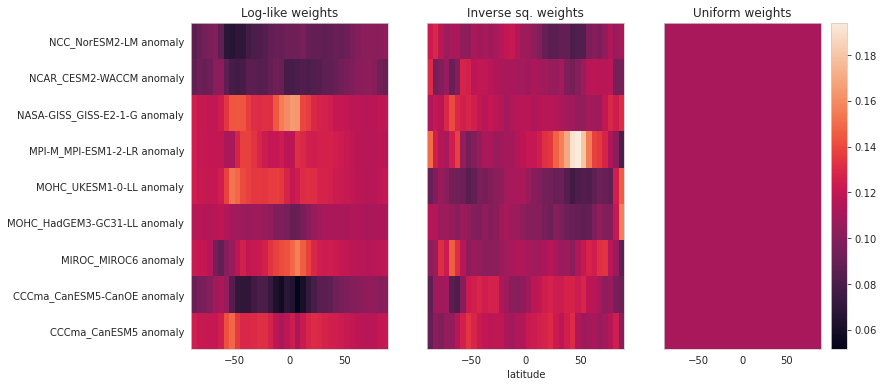

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 6))
vmax = np.max([ll_weights.mean(['time', 'longitude']), weighted_weights.mean(['time', 'longitude'])])
vmin = np.min([ll_weights.mean(['time', 'longitude']), weighted_weights.mean(['time', 'longitude'])])

p1 = axes[0].pcolormesh(ll_weights.latitude, ll_weights.model, ll_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
plt.colorbar(p1)
axes[0].set_title('Log-like weights')
p2 = axes[1].pcolormesh(ll_weights.latitude, ll_weights.model, weighted_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
axes[1].set_title('Inverse sq. weights')
p3 = axes[2].pcolormesh(ll_weights.latitude, ll_weights.model, uniform_weights.mean(['time', 'longitude']).values, vmin=vmin, vmax=vmax)
axes[2].set_title('Uniform weights')
axes[1].set_xlabel('latitude')
plt.show()

Construct the barycentre

In [10]:
ssp_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True)

/home/pindert2/bayesian_ensembling/ensembles/models.py:101: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
Objective:  13135.06: 100%|██████████| 500/500 [00:01<00:00, 275.88it/s]


Average weights in time and them ensure that there is a weight per space and time

In [11]:
single_ll_weights = ll_weights.mean('time').expand_dims(time=ssp_anom_models[0].model_data.time, axis=1)

100%|██████████| 10368/10368 [02:13<00:00, 77.71it/s]
/home/amosm1/bayesian_ensembling/ensembles/data.py:87: UserWarning: Collapsing (mean) temporal dimensions for plotting
  warnings.warn("Collapsing (mean) temporal dimensions for plotting")
/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/cartopy/crs.

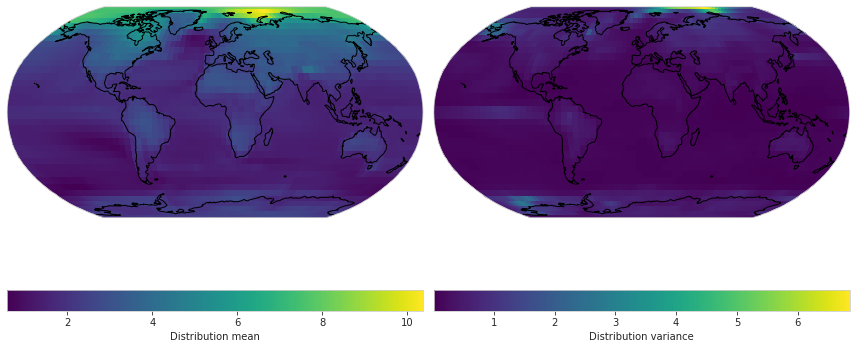

In [13]:
ensemble_method = es.Barycentre()
weighted_barycentre = ensemble_method(ssp_anom_models, single_ll_weights)

weighted_barycentre.plot_spatially()

In [34]:
mean = weighted_barycentre.mean[0]
std = np.sqrt(weighted_barycentre.variance)[0]

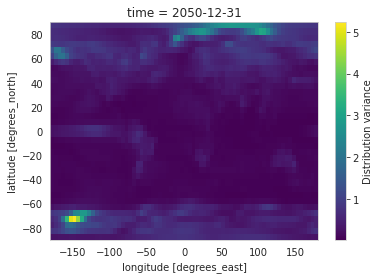

In [35]:
std.plot()

### Construct different ensemble outputs

In [15]:
weighted_mean = es.WeightedModelMean()(hist_anom_models, weights=weighted_weights)
multi_model_mean = es.MultiModelMean()(hist_anom_models, weights=None)